In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import random
import pathlib
import torch.utils.data as data
import PIL
import PIL.Image
from torchvision.datasets import ImageFolder
import pandas as pd

import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [5]:
class PairDataset(data.Dataset):
    def __init__(self, root, feature_suffix='_image.jpg', target_suffix='_mask.jpg', 
                 feature_transform=None, pair_transform=None, target_transform=None,
                 mode='train', val_split=0.2,
                 **kwargs):
        super(PairDataset, self).__init__()
        self.root = pathlib.Path(root)
        self.feature_suffix = feature_suffix
        self.target_suffix = target_suffix
        self.mode = mode
        self.val_split = val_split
        self.feature_files = None
        self.target_files = None
        self.feature_transform = feature_transform
        self.pair_transform = pair_transform
        self.target_transform = target_transform
        self.kwargs = kwargs
        self._build_files()
        self._split_validation()
        
    def _build_files(self):
        self.feature_files = sorted(list(self.root.glob(f"*{self.feature_suffix}")))
        self.target_files = sorted(list(self.root.glob(f"*{self.target_suffix}")))
        feat_len = len(self.feature_files)
        targ_len = len(self.target_files)
        assert feat_len == targ_len, "Total files from feature dir and target " \
                                     "dir is not equal, expected equal number"

    def _split_validation(self):
        total = len(self.feature_files)
        val_total = int(total * self.val_split)
        trx_total = int(total - val_total)
        index_list = [i for i in range(total)]
        random.seed(1261)
        trx_indices = random.sample(index_list, k=trx_total)
        val_indices = list(set(index_list) - set(trx_indices))
        
        if self.mode == "train":
            self.feature_files = list(map(lambda i: self.feature_files[i], trx_indices))
            self.target_files = list(map(lambda i: self.target_files[i], trx_indices))
        elif self.mode == "valid":
            self.feature_files = list(map(lambda i: self.feature_files[i], val_indices))
            self.target_files = list(map(lambda i: self.target_files[i], val_indices))
        else:
            raise Exception("supported mode only 'train' and 'valid'")
        
        
    def __len__(self):
        feat_len = len(list(self.feature_files))
        return feat_len
    
    def get_files(self, idx):
        feature_path = self.feature_files[idx]
        target_path = self.target_files[idx]
        
        fname = feature_path.name.split("_")[0]
        tname = target_path.name.split("_")[0]
        
        assert fname.split("_")[0] == tname.plit("_")[0], f"feature name {fname} is not same file with target name {tname}"

    def __getitem__(self, idx: int):
        feature_path = self.feature_files[idx]
        target_path = self.target_files[idx]
        
#         print(feature_path.name.split("_")[0], target_path.name.split("_")[0])

        feature = PIL.Image.open(feature_path)
        target = PIL.Image.open(target_path)

        if self.feature_transform:
            feature = self.feature_transform(feature)

        if self.pair_transform:
            feature, target = self.pair_transform(feature, target)

        if self.target_transform:
            target = self.target_transform(target)

        return feature, target
    

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# inspiration from
# https://github.com/pytorch/pytorch/issues/1249
# github.com/jeffwen/road_building_extraction/blob/master/src/utils/core.py
# and other source
def dice_coeff(input, target, smooth=1.):
    input_flat = input.view(-1)
    target_flat = target.view(-1)

    intersection = (input_flat * target_flat).sum()
    return (2. * intersection + smooth) / (input_flat.sum() + target_flat.sum() + smooth)


def dice_loss(input, target, smooth=1.0):
    dcoeff = dice_coeff(input, target, smooth=smooth)
    return 1-dcoeff

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, input, target):
        dcoeff = dice_coeff(input, target, smooth=self.smooth)
        return 1 - dcoeff

# inspiration from
# github.com/jeffwen/road_building_extraction/blob/master/src/utils/core.py
# and other source
class BCEDiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(BCEDiceLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_loss = DiceLoss(smooth=smooth)

    def forward(self, input, target):
        input_flat = input.view(-1)
        target_flat = target.view(-1)
        bce_loss = self.bce_loss(input_flat, target_flat).double()
        dice_loss = self.dice_loss(input, target)
        return bce_loss + dice_loss
    

In [21]:
import torch
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.metrics import Accuracy

class TaskUNet(pl.LightningModule):
    def __init__(self, model, optimizer, criterion):
        super().__init__()
        # self.save_hyperparameters()
        self.model = model
#         self.model = self.model.to(self.device)
        
        self.optimizer = optimizer
        self.criterion = criterion
        self.dice_metric = dice_loss
    
    def forward(self, imgs):
        output = self.model(imgs)
        return output
    

    def backward(self, loss, optimizer, optimizer_idx):
        loss.backward()
        
   
    def shared_step(self, batch, batch_idx):
        images, masks = batch
#         images = images.to(self.device)
#         masks = masks.to(self.device)
        
        output = self.model(images)
        output_sigmoid = torch.sigmoid(output)
        
        loss = self.criterion(output, masks)
        dice = self.dice_metric(output_sigmoid, masks)
        return loss, dice
        
        
    def training_step(self, batch, batch_idx):
        loss, dice = self.shared_step(batch, batch_idx)
        self.log('trn_loss', loss, prog_bar=True, logger=True)
        self.log('trn_dice', dice,  prog_bar=True, logger=True)
#         self.log('trn_distance', distance,  prog_bar=True, logger=True)
        
        return loss
        
    
    def validation_step(self, batch, batch_idx):
        loss, dice = self.shared_step(batch, batch_idx)
        self.log('val_loss', loss, prog_bar=True, logger=True)
        self.log('val_dice', dice,  prog_bar=True, logger=True)
#         self.log('val_distance', distance,  prog_bar=True, logger=True)
        
        return loss
        
    def configure_optimizers(self):
        return self.optimizer

In [22]:
from unet import transforms as PT
train_tmft = PT.PairCompose([
    PT.PairResize((256, 256)),
    PT.PairRandomRotation(20),
    PT.PairGrayscale(),
    PT.PairToTensor(),
#     PT.PairNormalize(mean=0.5, std=0.5)
])


valid_tmft = PT.PairCompose([
    PT.PairResize((256, 256)),
    PT.PairGrayscale(),
    PT.PairToTensor(),
#     PT.PairNormalize(mean=0.5, std=0.5)
    
])

trainset = PairDataset(root='/data/idcard/combined/1609935833',
                       pair_transform=train_tmft,
                       mode='train')

validset = PairDataset(root='/data/idcard/combined/1609935833',
                       pair_transform=valid_tmft,
                       mode='valid')

In [9]:
train_loader = data.DataLoader(trainset, batch_size=24, shuffle=True, num_workers=16)
valid_loader = data.DataLoader(validset, batch_size=24, shuffle=True, num_workers=16)

In [23]:
from unet.models.resnet_unet import ResNetUNet
from unet.models.tunnable_unet import TuneableUNet
from unet.models.unet import UNet

# model = UNet(in_chan=1, n_classes=1, start_feat=32)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
task = TaskUNet(model, optimizer, criterion)

In [24]:
# DEFAULTS used by the Trainer
SAVED_CHECKPOINT_PATH = 'checkpoints/'
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=SAVED_CHECKPOINT_PATH,
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min',
    prefix='ocrnet'
)

SAVED_LOGS_PATH = 'logs/'
tb_logger = pl_loggers.TensorBoardLogger(SAVED_LOGS_PATH)

trainer = pl.Trainer(
    weights_summary="top",
    max_epochs=100,
    val_check_interval=500,
    gpus=1,
    logger=tb_logger, 
    checkpoint_callback=checkpoint_callback, 
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [25]:
trainer.fit(task, train_loader, valid_loader)


  | Name      | Type              | Params
------------------------------------------------
0 | model     | UNet              | 3 M   
1 | criterion | BCEWithLogitsLoss | 0     
/opt/anaconda3/envs/dlearn/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Epoch 0: val_loss reached 0.00627 (best 0.00627), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v6.ckpt as top 1


Epoch 0: val_loss was not in top 1


Epoch 1: val_loss was not in top 1


Epoch 1: val_loss was not in top 1


Epoch 2: val_loss was not in top 1


Epoch 2: val_loss reached 0.00622 (best 0.00622), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v7.ckpt as top 1


Epoch 3: val_loss reached 0.00618 (best 0.00618), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v6.ckpt as top 1


Epoch 3: val_loss reached 0.00617 (best 0.00617), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v7.ckpt as top 1


Epoch 4: val_loss was not in top 1


Epoch 4: val_loss reached 0.00615 (best 0.00615), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v6.ckpt as top 1


Epoch 5: val_loss was not in top 1


Epoch 5: val_loss was not in top 1


Epoch 6: val_loss was not in top 1


Epoch 6: val_loss reached 0.00613 (best 0.00613), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v7.ckpt as top 1


Epoch 7: val_loss reached 0.00613 (best 0.00613), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v6.ckpt as top 1


Epoch 7: val_loss reached 0.00611 (best 0.00611), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v7.ckpt as top 1


Epoch 8: val_loss was not in top 1


Epoch 8: val_loss was not in top 1


Epoch 9: val_loss was not in top 1


Epoch 9: val_loss was not in top 1


Epoch 10: val_loss was not in top 1


Epoch 10: val_loss was not in top 1


Epoch 11: val_loss was not in top 1


Epoch 11: val_loss was not in top 1


Epoch 12: val_loss was not in top 1


Epoch 12: val_loss was not in top 1


Epoch 13: val_loss was not in top 1


Epoch 13: val_loss was not in top 1


Epoch 14: val_loss was not in top 1


Epoch 14: val_loss reached 0.00611 (best 0.00611), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v6.ckpt as top 1


Epoch 15: val_loss was not in top 1


Epoch 15: val_loss was not in top 1


Epoch 16: val_loss was not in top 1


Epoch 16: val_loss reached 0.00609 (best 0.00609), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v7.ckpt as top 1


Epoch 17: val_loss reached 0.00609 (best 0.00609), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v6.ckpt as top 1


Epoch 17: val_loss was not in top 1


Epoch 18: val_loss was not in top 1


Epoch 18: val_loss was not in top 1


Epoch 19: val_loss reached 0.00609 (best 0.00609), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v7.ckpt as top 1


Epoch 19: val_loss was not in top 1


Epoch 20: val_loss was not in top 1


Epoch 20: val_loss was not in top 1


Epoch 21: val_loss was not in top 1


Epoch 21: val_loss reached 0.00609 (best 0.00609), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v6.ckpt as top 1


Epoch 22: val_loss reached 0.00605 (best 0.00605), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v7.ckpt as top 1


Epoch 22: val_loss reached 0.00605 (best 0.00605), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v6.ckpt as top 1


Epoch 23: val_loss reached 0.00604 (best 0.00604), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v7.ckpt as top 1


Epoch 23: val_loss was not in top 1


Epoch 24: val_loss was not in top 1


Epoch 24: val_loss reached 0.00602 (best 0.00602), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v6.ckpt as top 1


Epoch 25: val_loss was not in top 1


Epoch 25: val_loss was not in top 1


Epoch 26: val_loss reached 0.00601 (best 0.00601), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v7.ckpt as top 1


Epoch 26: val_loss was not in top 1


Epoch 27: val_loss was not in top 1


Epoch 27: val_loss was not in top 1


Epoch 28: val_loss was not in top 1


Epoch 28: val_loss was not in top 1


Epoch 29: val_loss was not in top 1


Epoch 29: val_loss reached 0.00600 (best 0.00600), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v6.ckpt as top 1


Epoch 30: val_loss was not in top 1


Epoch 30: val_loss reached 0.00599 (best 0.00599), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v7.ckpt as top 1


Epoch 31: val_loss was not in top 1


Epoch 31: val_loss reached 0.00599 (best 0.00599), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v6.ckpt as top 1


Epoch 32: val_loss was not in top 1


Epoch 32: val_loss was not in top 1


Epoch 33: val_loss was not in top 1


Epoch 33: val_loss was not in top 1


Epoch 34: val_loss was not in top 1


Epoch 34: val_loss was not in top 1


Epoch 35: val_loss was not in top 1


Epoch 35: val_loss was not in top 1


Epoch 36: val_loss was not in top 1


Epoch 36: val_loss reached 0.00596 (best 0.00596), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v7.ckpt as top 1


Epoch 37: val_loss was not in top 1


Epoch 37: val_loss was not in top 1


Epoch 38: val_loss reached 0.00596 (best 0.00596), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v6.ckpt as top 1


Epoch 38: val_loss was not in top 1


Epoch 39: val_loss was not in top 1


Epoch 39: val_loss was not in top 1


Epoch 40: val_loss was not in top 1


Epoch 40: val_loss was not in top 1


Epoch 41: val_loss was not in top 1


Epoch 41: val_loss was not in top 1


Epoch 42: val_loss was not in top 1


Epoch 42: val_loss was not in top 1


Epoch 43: val_loss was not in top 1


Epoch 43: val_loss was not in top 1


Epoch 44: val_loss was not in top 1


Epoch 44: val_loss was not in top 1


Epoch 45: val_loss reached 0.00595 (best 0.00595), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v7.ckpt as top 1


Epoch 45: val_loss reached 0.00594 (best 0.00594), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v6.ckpt as top 1


Epoch 46: val_loss was not in top 1


Epoch 46: val_loss reached 0.00593 (best 0.00593), saving model to /home/tigapilar/project/unet.pytorch/ocrnet-checkpoints-v7.ckpt as top 1


Epoch 47: val_loss was not in top 1


Epoch 47: val_loss was not in top 1


Epoch 48: val_loss was not in top 1


Epoch 48: val_loss was not in top 1


Epoch 49: val_loss was not in top 1


Epoch 49: val_loss was not in top 1


Epoch 50: val_loss was not in top 1


Epoch 50: val_loss was not in top 1


Epoch 51: val_loss was not in top 1


Epoch 51: val_loss was not in top 1


Epoch 52: val_loss was not in top 1


Epoch 52: val_loss was not in top 1


Epoch 53: val_loss was not in top 1


Epoch 53: val_loss was not in top 1


Epoch 54: val_loss was not in top 1


Epoch 54: val_loss was not in top 1


Epoch 55: val_loss was not in top 1


Epoch 55: val_loss was not in top 1


Epoch 56: val_loss was not in top 1


Epoch 56: val_loss was not in top 1


Epoch 57: val_loss was not in top 1


Epoch 57: val_loss was not in top 1


Epoch 58: val_loss was not in top 1


Epoch 58: val_loss was not in top 1


Epoch 59: val_loss was not in top 1


Epoch 59: val_loss was not in top 1


Epoch 60: val_loss was not in top 1
/opt/anaconda3/envs/dlearn/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Epoch 60: val_loss was not in top 1


1

In [38]:
state_dict = task.model.state_dict()
unet_path = 'weights/unet_sfeat32.pth'
torch.save(state_dict, unet_path)

In [40]:
unet_path = 'weights/unet_sfeat32.pth'
state_dict = torch.load(unet_path)
model = UNet(in_chan=1, n_classes=1, start_feat=32)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [41]:
imgs, mask = next(iter(valid_loader))
output = task.model(imgs)
output = torch.sigmoid(output)
output.shape

torch.Size([24, 1, 256, 256])

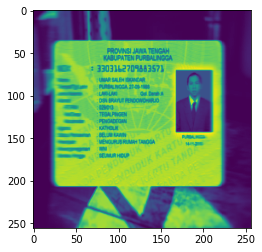

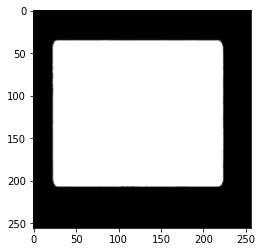

In [44]:
idx = 12
plt.imshow(imgs[idx].squeeze());plt.show()
plt.imshow(output[idx].squeeze().cpu().detach().numpy(), cmap='gray')

In [13]:
mask.shape

torch.Size([8, 1, 512, 512])

In [14]:
# random.seed(1261)
# index_list = [i for i in range(5)]
# index = random.sample(index_list, k=2)

In [15]:
# ls = ["satu", "dua", "tiga", "empat", "lima"]
# list(map(lambda i: ls[i], index))